In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st 
import math
import statsmodels.api as sm
import pandas as pd
from scipy.optimize import bisect

In [113]:
def I(sigma, S_0 = 100 , K = 120, r = 0.05, T = 0.2):
    """Closed form solution of an european put option of a geometric brownian motion with equidistant time steps adjusted to the market price
    Parameters
    ----------
    sigma : float
        volatility of the geometric brownian motion
    I_market : float
        Market price of such put options
    S_0 : float
        Initial value of the geometric brownian motion
    K : float
        strike price of the put option
    r : float
        interest rate of the put option
    sigma : float
        volatility of the geometric brownian motion
    T : float
        time horizon of the put option

    Returns
    -------
    I : float
        Mark to market price of the put option"""
    
    w = (np.log(K/S_0) - (r-0.5*sigma**2)*T) / ( sigma * np.sqrt(T) )
    I = np.exp(-r*T) * K * st.norm.cdf(w) - S_0 * st.norm.cdf(w - sigma*np.sqrt(T))
    return I

def Simulate_Stock_Price(S_0,sigma, r, T, m,N):
    """This function returns m GBM, each evaluated at time t starting at s_0

    Parameters
    ----------
    s_0 : float
        Initial value of the geometric Brownian motion
    sigma : float
        Volatility of the geometric Brownian motion
    r : float
        Interest rate of the geometric Brownian motion
    t : float
        Time horizon of the geometric Brownian motion
    N : int
        Number of GBM to generate

    Returns
    -------
    S : np.ndarray
        m GBM evaluated at time t (m_features,)
    """

    if m == 1:
        return S_0 * st.lognorm.rvs(s = np.sqrt( sigma ** 2 * T), loc = 0, scale = np.exp((r-0.5*sigma**2) * T), size = N)

    simulations = np.ndarray((N,m+1))
    simulations[:,0] = S_0
    expXt = st.lognorm.rvs(s = np.sqrt( sigma ** 2 * T/m), loc = 0, scale = np.exp((r-0.5*sigma**2) * T/m), size = m*N)
    for j in range(m):
        simulations[:,j+1] = simulations[:,j] * expXt[j*N : (j+1)*N]
    return simulations

def RM_European(n, N, rho, K, S0, T, r, I_market):
    sigma_0 = 1
    alpha_0 = 2/(K+S0)

    sigma_estim = np.empty((n,))
    sigma_estim[0] = sigma_0
    
    for i in range(1, n):
        alpha_n = alpha_0 / i ** rho
        sigma_cur = sigma_estim[i - 1]

        # Compute Jhat
        stock_prices = Simulate_Stock_Price(S0, sigma_cur, r, T, m=1, N=N)
        payoffs = np.exp(-r*T) * np.maximum(K - stock_prices, 0)
        Jhat = np.mean(payoffs) - I_market

        sigma_estim[i] = sigma_cur - alpha_n * Jhat

    return sigma_estim

Calculate the 'true' implied volatility

In [114]:
I_m = 22
sigma_opt = bisect(lambda sigma: I(sigma) - I_m, 0.01, 10)
print(sigma_opt)

0.508372926009589


Apply RM Algorithm to find the implied volality. Estimation of the Mean Squared Error (MSE).

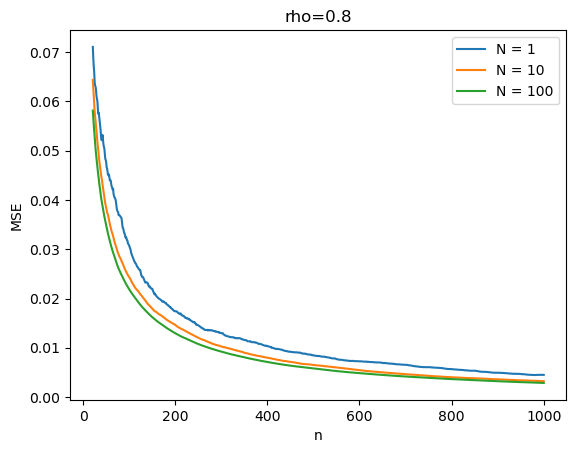

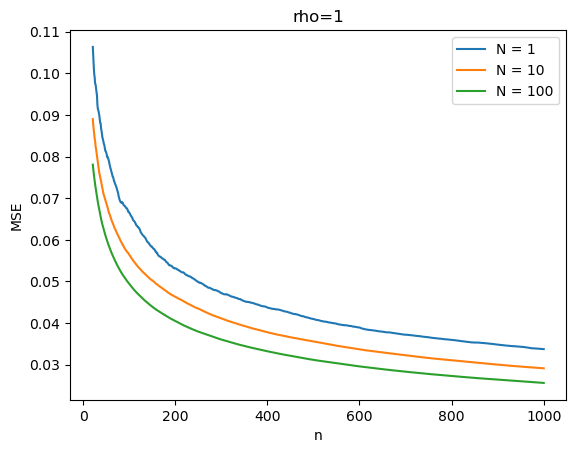

In [115]:
n = 1000
iterations = 100
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22
for rho in [0.8,1]:
    plt.figure()
    plt.title('rho=' + str(rho))
    for N in [1,10,100]:
        # Estimate expectation of MSE
        all_sigma_estim = np.empty((iterations,), dtype=np.ndarray)
        for i in range(iterations):
            all_sigma_estim[i] = RM_European(n, N, rho, K, S0, T, r, I_market)
        MSE = np.mean((all_sigma_estim - sigma_opt)**2, axis=0)

        plt.plot(np.arange(21, n+1), MSE[20:], label='N = ' + str(N))
    plt.legend()
    plt.xlabel('n')
    plt.ylabel('MSE')

RM Algorithm to find implied volatility for Asian put option with I_market = 22

In [116]:
def RM_Asian(n, N, rho, K, S0, T, r, I_market, m, sigma_0=1):
    """ Crude MonteCarlo estimator for Robin_Monro algorithm
    Parameters
    ----------
    sigma : float
        volatility of the geometric brownian motion
    N : int
        Size of the sample size for the estimation of the expected value
    K : float
        strike price of the put option
    S_0 : float
        Initial value of the geometric brownian motion
    r : float
        interest rate of the put option
    T : float
        time horizon of the put option
    I_market : float
        consistent mark to market price of the put option
    m : int
        number of time steps
    
    Returns
    -------
    J : float
        Crude MonteCarlo estimator of the the expected value of the payoff of the put option"""

    alpha_0 = 2/(K+S0)

    sigma_estim = np.empty((n,))
    sigma_estim[0] = sigma_0
    
    for i in range(1, n):
        alpha_n = alpha_0 / i ** rho
        sigma_cur = sigma_estim[i - 1]

        # Calculate Jhat
        simulations = Simulate_Stock_Price(S0, sigma_cur, r, T, m, N)
        avg_stock_prices = np.mean(simulations[:, 1:], axis=1)
        payoffs = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0)
        Jhat = np.mean(payoffs) - I_market

        sigma_estim[i] = sigma_cur - alpha_n * Jhat

    return sigma_estim

Text(0, 0.5, 'sigma')

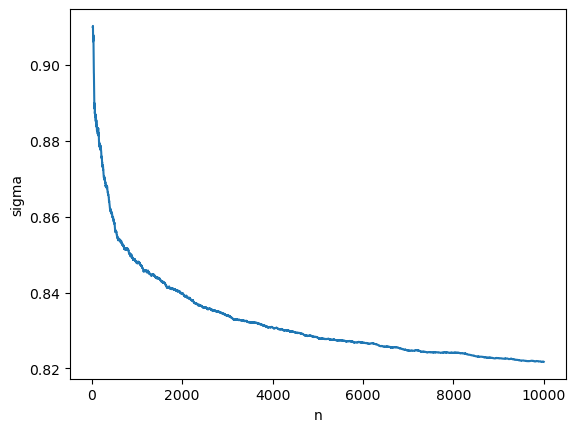

In [118]:
n=10000
N=100
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22

sigmas = RM_Asian(n, N, rho=0.8, K=K, S0=S0, T=T, r=r, I_market=I_market, m=30)
plt.plot(range(21,n+1), sigmas[20:])
plt.xlabel('n')
plt.ylabel('sigma')

In [119]:
N=10000
Jhat, est_std, est_skew = Jhat_Asian(sigmas[-1])
margin = 1.96 * est_std / np.sqrt(N)
lower_bound = Jhat - margin
upper_bound = Jhat + margin

# Print the confidence interval
print(f"CLT 95% Confidence Interval: ({lower_bound}, {upper_bound})")

margin = est_std / np.sqrt(0.05*N)
lower_bound = Jhat - margin
upper_bound = Jhat + margin
# Chebyshev
print(f"Chebyshev 95% Confidence Interval: ({lower_bound}, {upper_bound})")

k = 0.4748
xalpha = st.norm.ppf(k * est_std*est_skew**3/(np.sqrt(N) * est_std**3) + 1 - 0.05/2)
margin = xalpha * est_std / np.sqrt(N)
lower_bound = Jhat - margin
upper_bound = Jhat + margin
# Barry-Essen
print(f"Barry-Essen 95% Confidence Interval: ({lower_bound}, {upper_bound})")


CLT 95% Confidence Interval: (0.44677845513487435, 1.113500872273051)
Chebyshev 95% Confidence Interval: (0.01950872143664939, 1.540770605971276)
Barry-Essen 95% Confidence Interval: (0.446783678820656, 1.1134956485872693)


In [120]:
def calculate_bounds(r, T, S0, K, m):
    diff = K - S0 * np.mean(np.exp(r * np.arange(1,m+1) * T / m))
    diff = diff if diff > 0 else 0
    return str((np.exp(-r*T)*diff, np.exp(-r*T)*K))

print('Old bounds for I_market: ' + calculate_bounds(r=0.05, T=0.2, S0=100, K=120, m=50))
print('New bounds for I_market: ' + calculate_bounds(r=0.05, T=0.2, S0=100, K=80, m=50))

Old bounds for I_market: (19.294367043657672, 118.80598004990017)
New bounds for I_market: (0.0, 79.20398669993345)


In [222]:
# Question 6: Important Sampling

# Part a) Use IS to approximate I(sigma). Note: Jhat(sigma) = Ihat(sigma) - I_market

# Calculate likelihood ratio
def w(S_T, S_0, sigma, r, r_tilde, T):
    return (S_T/S_0)**((r - r_tilde)/sigma**2) * np.exp((r+r_tilde-sigma**2)*(-r+r_tilde)*T/(2*sigma**2))

def RM_Asian_with_IS(n, N, rho, K, S0, T, r, r_tilde, I_market, m):
    sigma_0 = 1
    alpha_0 = 2/(K+S0)

    sigma_estim = np.empty((n,))
    sigma_estim[0] = sigma_0
    
    for i in range(1, n):
        alpha_n = alpha_0 / i ** rho
        sigma_cur = sigma_estim[i - 1]

        # Calculate Jhat with IS
        simulations = Simulate_Stock_Price(S0, sigma_cur, r_tilde, T, m, N)
        likelihood_ratios = w(simulations[:, -1], S0, sigma_cur, r, r_tilde, T)
        avg_stock_prices = np.mean(simulations[:, 1:], axis=1)
        payoffs = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0)
        Jhat = np.mean(np.multiply(payoffs, likelihood_ratios)) - I_market

        sigma_estim[i] = sigma_cur - alpha_n * Jhat

    return sigma_estim

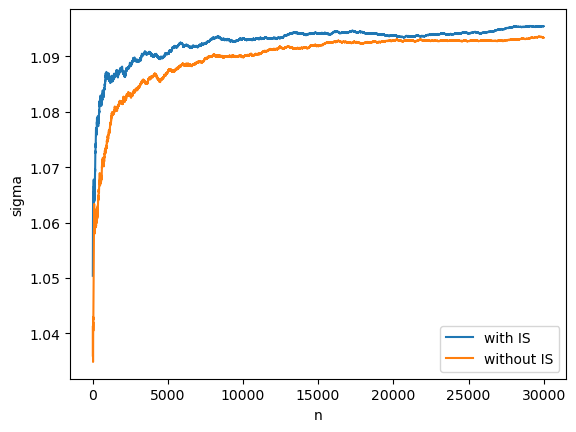

In [223]:
n, N, rho = 30000, 10, 0.8
K, S0, T, r, I_market = 80, 100, 0.2, 0.05, 3
r_tilde = 10**-6
m = 30

sigmas_IS = RM_Asian_with_IS(n, N, rho, K, S0, T, r, r_tilde, I_market, m)
plt.plot(range(21,n+1), sigmas_IS[20:], label="with IS")

sigmas = RM_Asian(n, N, rho, K, S0, T, r, I_market, m)
plt.plot(range(21,n+1), sigmas[20:], label="without IS")

plt.xlabel('n')
plt.ylabel('sigma')
plt.legend()

In [234]:
# Question 7
from scipy.optimize import minimize_scalar

K, S0, T, r = 80, 100, 0.2, 0.05
m = 30
N = 100
def find_optimal_r_tilde(sigmas, S0, K, r, T, m, N):
    def g(eta, sigma, simulations):
        likelihood_ratios = w(simulations[:, -1], S0, sigma, r, eta, T)
        
        avg_stock_prices = np.mean(simulations[:, 1:], axis=1)
        payoffs_squared = (np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0))**2
        variance = np.mean(np.multiply(payoffs_squared, likelihood_ratios))
        return variance
    
    if type(sigmas) == float:
        simulations = Simulate_Stock_Price(S0, sigma, r, T, m, N)
        return minimize_scalar(g, args=(sigmas,simulations), bounds = (0, 1)).x
    else:
        result = {}
        for sigma in sigmas:
            simulations = Simulate_Stock_Price(S0, sigma, r, T, m, N)
            result[sigma] = minimize_scalar(g, args=(sigma,simulations), bounds = (0, 1)).x

        return result
sigmas = np.linspace(0.3, 5, num=1000)
result = find_optimal_r_tilde(sigmas, S0, K, r, T, m, N)

In [235]:
def RM_Asian_with_IS_opt(n, N, rho, K, S0, T, r, I_market, m):
    sigma_0 = 1
    alpha_0 = 2/(K+S0)

    sigma_estim = np.empty((n,))
    sigma_estim[0] = sigma_0
    
    for i in range(1, n):
        alpha_n = alpha_0 / i ** rho
        sigma_cur = sigma_estim[i - 1]

        # Calculate Jhat with IS
        r_tilde = result[min(result, key=lambda x : abs(x - sigma_cur))]
        simulations = Simulate_Stock_Price(S0, sigma_cur, r_tilde, T, m, N)
        likelihood_ratios = w(simulations[:, -1], S0, sigma_cur, r, r_tilde, T)
        avg_stock_prices = np.mean(simulations[:, 1:], axis=1)
        payoffs = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0)
        Jhat = np.mean(np.multiply(payoffs, likelihood_ratios)) - I_market

        sigma_estim[i] = sigma_cur - alpha_n * Jhat

    return sigma_estim

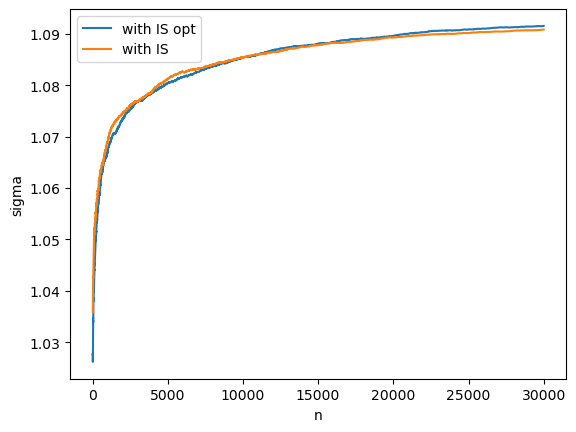

In [236]:
sigmas_IS = RM_Asian_with_IS_opt(n, N, rho, K, S0, T, r, I_market, m)
plt.plot(range(21,n+1), sigmas_IS[20:], label="with IS opt")

sigmas_IS = RM_Asian_with_IS(n, N, rho, K, S0, T, r, r_tilde, I_market, m)
plt.plot(range(21,n+1), sigmas_IS[20:], label="with IS")

plt.xlabel('n')
plt.ylabel('sigma')
plt.legend()